In [1]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
# path ke file csv dimasukkan ke variabel
data_path = os.path.join(os.getcwd(), 'preprocessed_data.csv')

# masukkan dataset ke dalam variabel df
df = pd.read_csv(data_path)

In [3]:
# mendefinisi kolom yang memprediksi (xcol) dan diprediksi (ycol) 
ycol = 'booking_earned'  
xcol = ['stay_duration_in_days', 'booking_window', 'distance_to_coastline', 'lat', 
        'bedroom', 'review_sentiment_score', 'lng', 'beds', 'rating']

In [4]:
# bagi data jadi set training dan testing
x_train, x_test, y_train, y_test = train_test_split(df[xcol], df[ycol], test_size=0.2, random_state=42)

In [5]:
# inisialisasi RandomForestRegressor
rf_regressor = RandomForestRegressor(n_estimators=200, random_state=42, bootstrap=False)

# train model
rf_regressor.fit(x_train, y_train)

# prediksi di test set
y_pred_train = rf_regressor.predict(x_train)
y_pred_test = rf_regressor.predict(x_test)

Training MAE: 19003.0769322941
Test MAE: 60621.265973749985


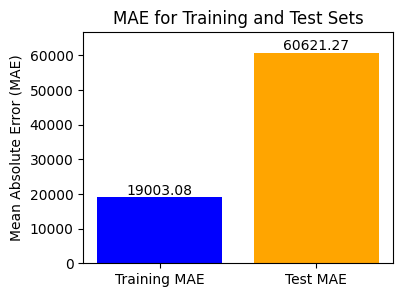

In [6]:
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt

# evaluasi model pakai MAE
train_mae = mean_absolute_error(y_train, y_pred_train)
test_mae = mean_absolute_error(y_test, y_pred_test)

print(f'Training MAE: {train_mae}')
print(f'Test MAE: {test_mae}')

# visualisasi MAE
labels = ['Training MAE', 'Test MAE']
values = [train_mae, test_mae]

plt.figure(figsize=(4, 3))
plt.bar(labels, values, color=['blue', 'orange'])
plt.ylabel('Mean Absolute Error (MAE)')
plt.title('MAE for Training and Test Sets')
plt.ylim(0, max(values) * 1.1)  
for i, v in enumerate(values):
    plt.text(i, v + 0.01, f'{v:.2f}', ha='center', va='bottom')  
plt.show()

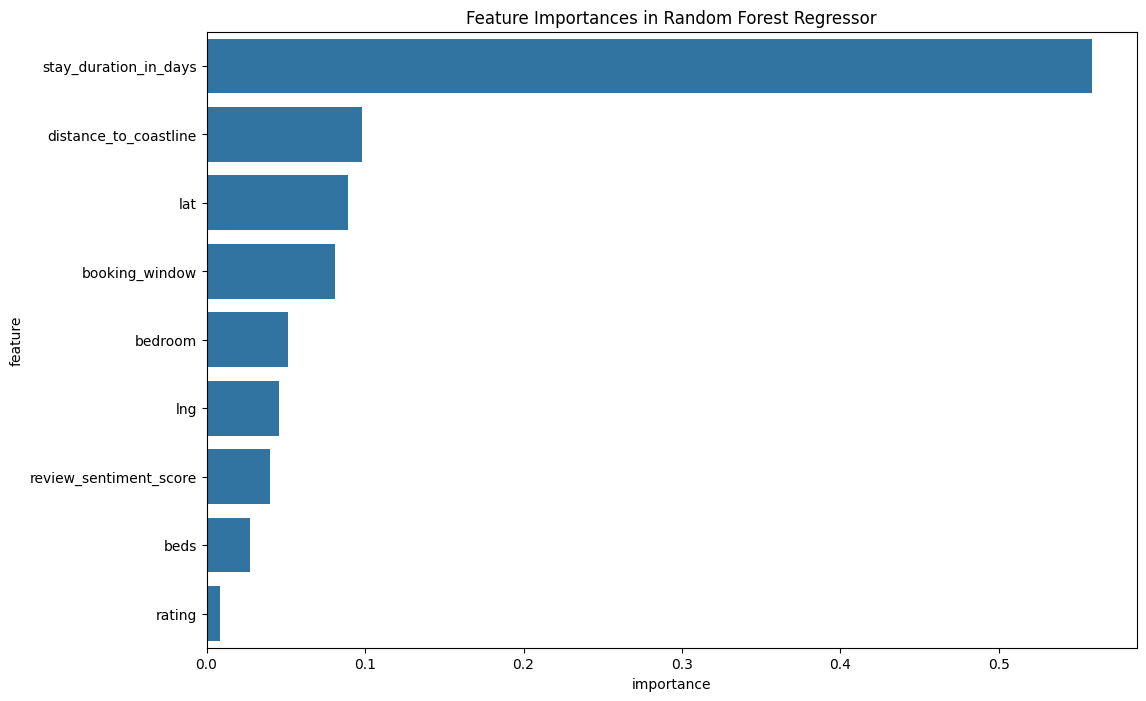

In [7]:
# untuk melihat variabel mana yang paling mempengaruhi

import matplotlib.pyplot as plt
import seaborn as sns

# inisialisasi feature importances
feature_importances = rf_regressor.feature_importances_

# buat dataframe untuk visualisasi
feature_importances_df = pd.DataFrame({
    'feature': x_train.columns,
    'importance': feature_importances
}).sort_values(by='importance', ascending=False)

# tampilkan feature importances
plt.figure(figsize=(12, 8))
sns.barplot(x='importance', y='feature', data=feature_importances_df)
plt.title('Feature Importances in Random Forest Regressor')
plt.show()